In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import layers
from tensorflow.keras import layers, models


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Saarathy Mithran/Downloads/DATASETS (SA3)/s/Potato",
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 4304 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Early Blight', 'Healthy', 'Late Blight']

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 2 2 0 2 2 2 2 2 2 0 0 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0]


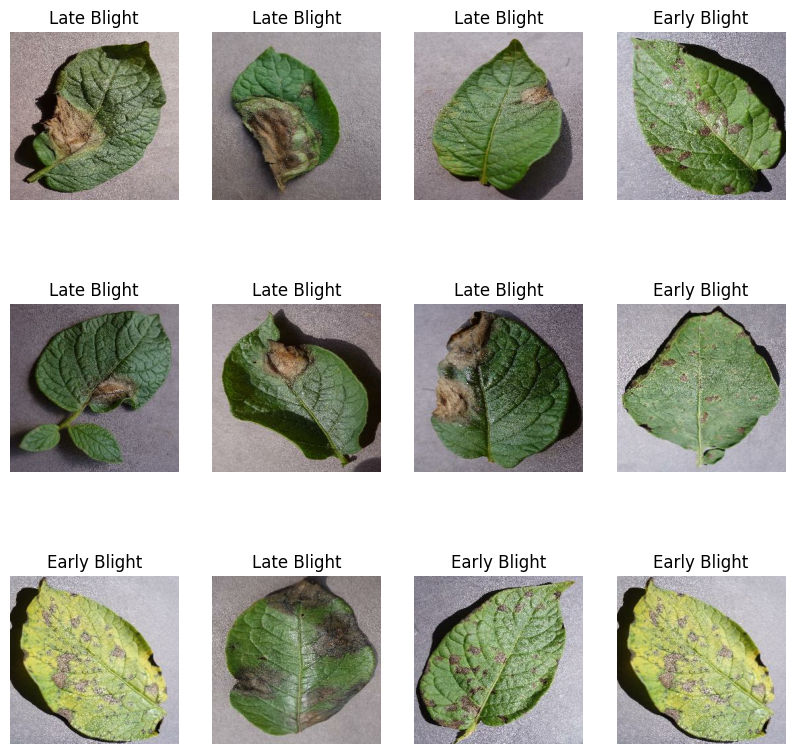

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
train_size = 0.8
len(dataset)*train_size

108.0

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

81

In [9]:
val_size=0.1
len(dataset)*val_size

13.5

In [10]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds)

75

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (256, 256, 3)
n_classes = 10

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, *input_shape))



C:\Users\Saarathy Mithran\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.4657 - loss: 3.8920 - val_accuracy: 0.8175 - val_loss: 0.4686
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.8064 - loss: 0.4536 - val_accuracy: 0.8775 - val_loss: 0.3097
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8877 - loss: 0.2597 - val_accuracy: 0.8925 - val_loss: 0.2711
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9014 - loss: 0.2446 - val_accuracy: 0.9075 - val_loss: 0.2620
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9217 - loss: 0.1997 - val_accuracy: 0.8425 - val_loss: 0.4420
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9295 - loss: 0.1810 - val_accuracy: 0.9475 - val_loss: 0.1256
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9343 - loss: 0.1663 - val_accuracy: 0.9275 - val_loss: 0.1681
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9300 - loss: 0.1635 - val_accu

In [22]:
scores = model.evaluate(test_ds)
scores

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9982 - loss: 0.0098


[0.012122588232159615, 0.9977678656578064]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 108}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
type(history.history['loss'])

list

In [27]:
history.history['loss'][:5]

[1.435041069984436,
 0.39035946130752563,
 0.2660805881023407,
 0.23806355893611908,
 0.18894606828689575]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

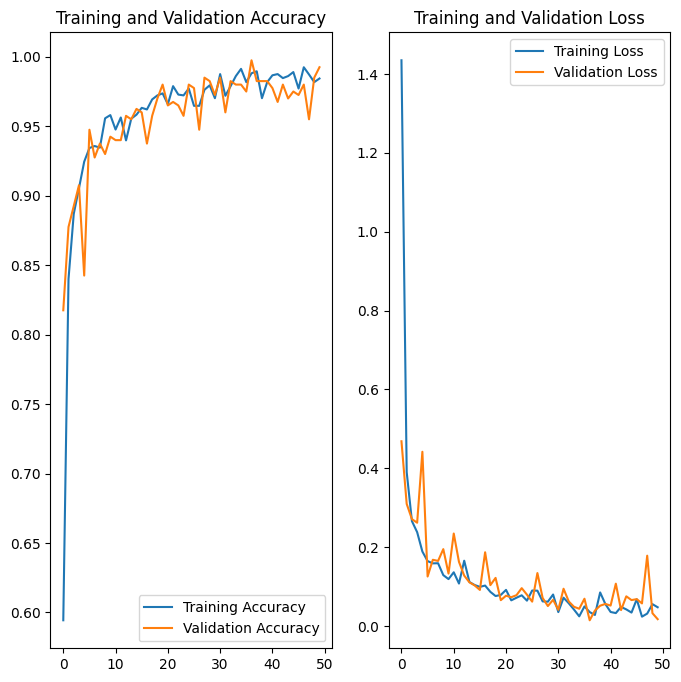

In [31]:
epochs = len(acc) 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
predicted label: Late Blight


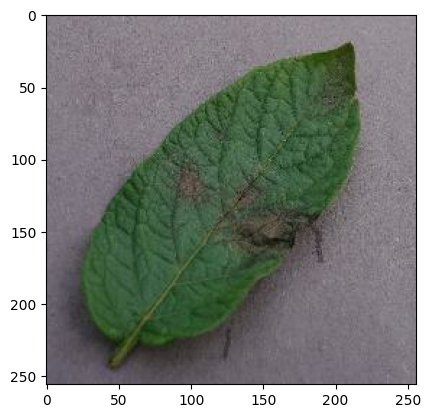

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


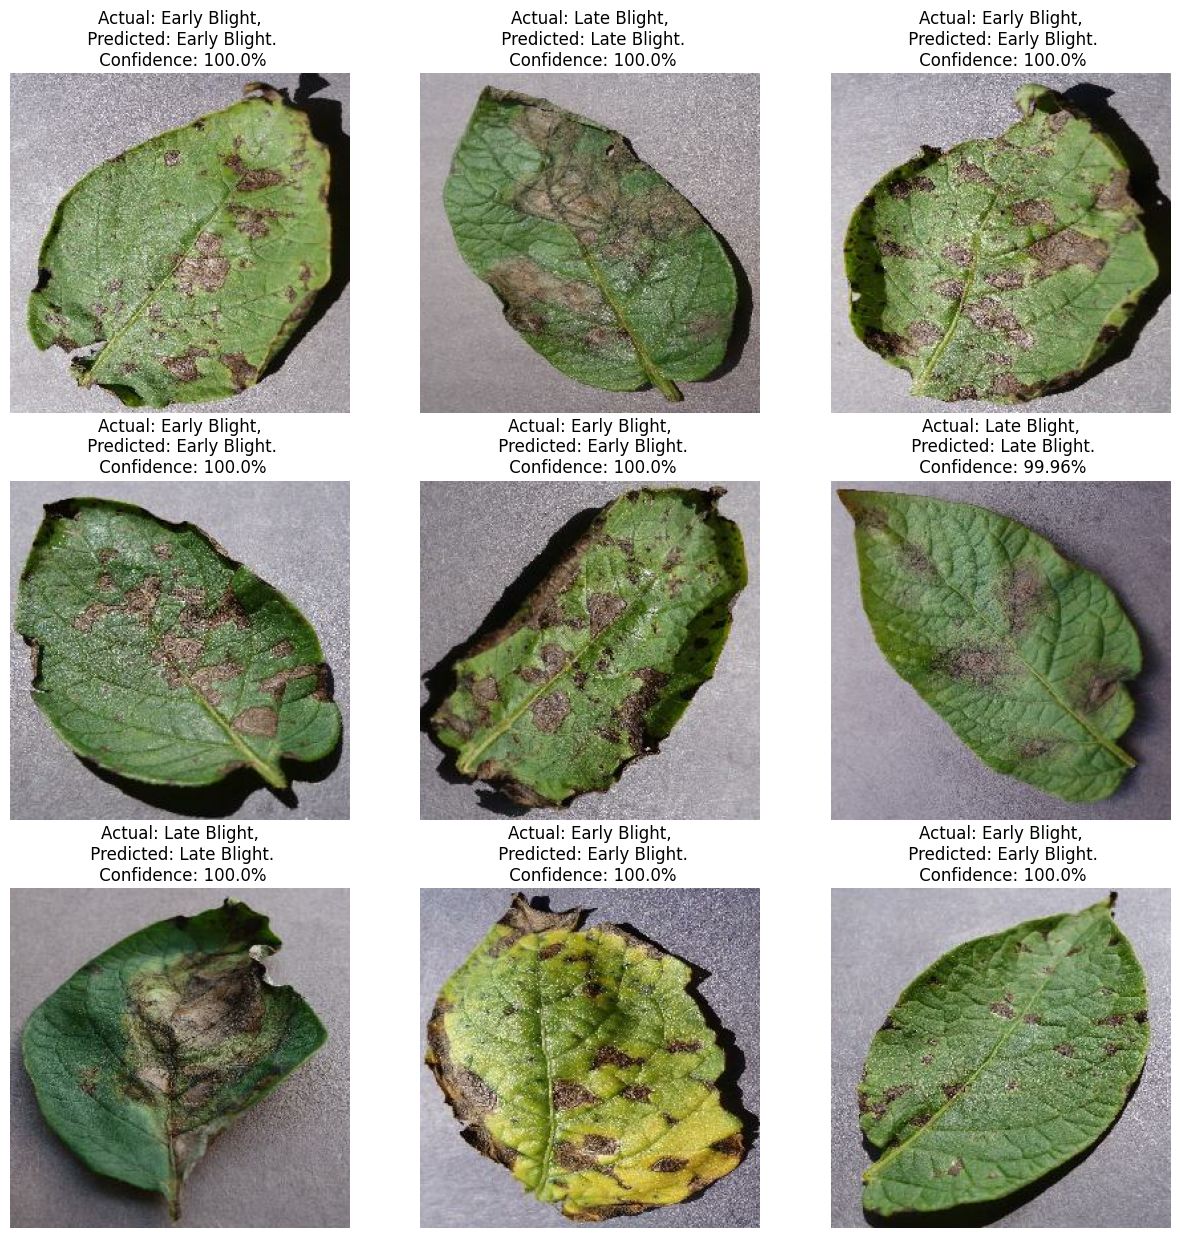

In [34]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import os

models_dir = "C:/Users/Saarathy Mithran/Downloads/DATASETS (SA3)/s/models"

os.makedirs(models_dir, exist_ok=True)

model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1

save_dir = f"C:/Users/Saarathy Mithran/Downloads/DATASETS (SA3)/s/{model_version}/"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "model.keras"))


In [38]:

model.save('Potato Model.keras')

: 